In [1]:
#Importing necessary libraries
import pandas as pd
import gzip
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from google.colab import drive
from sklearn.metrics import roc_curve, auc
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load dataset from JSON gzip file
file_path = '/content/drive/MyDrive/AMAZON_FASHION.json.gz'

with gzip.open(file_path) as f:
  df = pd.read_json(f, lines = True)


In [3]:
# Select only the relevant columns
df_new = df[['overall','verified','reviewTime','reviewText']]

In [4]:
# Check for missing values
df_new.isna().sum()

overall          0
verified         0
reviewTime       0
reviewText    1233
dtype: int64

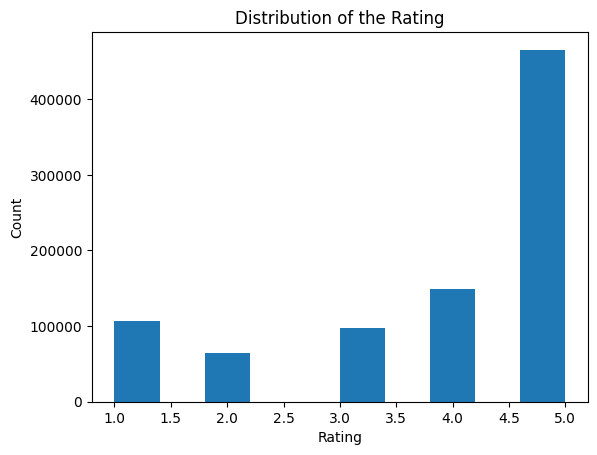

In [5]:
# Perform exploratory data analysis on rating distribution
plt.hist(df_new['overall'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of the Rating')
plt.show()

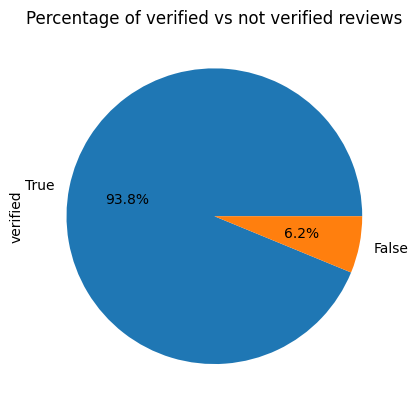

In [6]:
# Visualize the percentage of verified vs not verified reviews using a pie chart
df_values = df_new['verified'].value_counts()
df_values.plot(kind = 'pie' ,autopct='%1.1f%%')
plt.title('Percentage of verified vs not verified reviews')
plt.show()

In [23]:
# Remove unverified reviews as they constitute only 6% of total
df_drop = df_new.drop(df_new[df_new['verified']==False].index)
df = df_drop.reset_index(drop = True)

In [8]:
# Drop any remaining missing values
df = df.dropna()

In [9]:
df = df.copy()

In [10]:
# Change the format of the reviewTime to datetime and create a new column 'year'
df.loc[:, 'reviewTime'] = pd.to_datetime(df['reviewTime'], format = '%m %d, %Y')

In [11]:
df['year'] = df['reviewTime'].dt.year

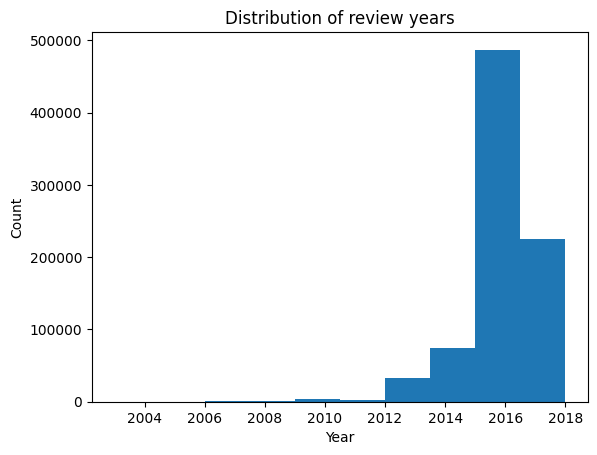

In [12]:
# Visualize the distribution of review years
plt.hist(df['year'])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of review years')
plt.show()

In [13]:
# Check first 50 reviews to see if any cleaning is required
for i in range (50):
  print(df['reviewText'].values[i])

Exactly what I needed.
I agree with the other review, the opening is too small.  I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen.  Would not buy again but for the price, not sending back.
too tiny an opening
Exactly what I wanted.
These little plastic backs work great.  No more loosing "hook" earrings!  Wish I had ordered these sooner before I had lost some of my favorite earrings!
mother - in - law wanted it as a present for her sister. she liked it and said it would work.
Item is of good quality. Looks great, too. But it does not fit 100's! But it can be stretched to fit them if you carefully push bottom of case with your fingers. Then shove in a pack of 100's(max) and level it out as you close case stretching case closed. Leave a pk.in it for month or so & was la! Buxton is usually a good quality product!
I had used my last el-cheapo fake leather cigarette case for SEVEN YEARS. It still closed completely but 

In [14]:
# Define X (features) and Y (target)
X = df['reviewText']
Y = df['overall']

In [15]:
# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size = 0.1)

In [16]:
# Vectorize the text data for Naive Bayes model
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train) #fit and transform teh training data
X_test_vectorized = vectorizer.transform(X_test) # transorm the test data


In [17]:
# Train the Naive Bayes model and make predictions on the test set
nb_calssifier = MultinomialNB()
nb_calssifier.fit(X_train_vectorized, Y_train)
y_pred = nb_calssifier.predict(X_test_vectorized)

In [18]:
# Create a dataframe to compare true vs predicted values
result_df = pd.DataFrame({'True': Y_test, 'Predicted': y_pred, 'Review': X_test})
result_df


,True,Predicted,Review
717768,1,1,Did not fit in an XL and this dress fit a size...
577230,2,1,It's too small. I recommend getting one size b...
290494,3,4,Pro: velcro straps and prints.\nCons: doesn't ...
190241,5,5,Love these. I hate knees socks but had to have...
380012,2,1,I wanted to use this for my nose for a April F...
...,...,...,...
229427,2,4,A few items missing but satisfied kinda.
421171,2,3,"I am true size4, small, and expected the dress..."
132449,5,4,"I am 130 lbs, 34b busts, 28 waist, 40 hips. i ..."
438878,5,5,Held up commuting on public transit during Bos...


In [19]:
# Compute evaluation metrics to assess model performance
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(Y_test, y_pred , average='weighted')
print("Precision:", precision)

recall = recall_score(Y_test, y_pred, average='weighted')
print("Recall: ", recall)

f1 = f1_score(Y_test, y_pred, average='weighted')
print("F1_score:" , f1)

Accuracy: 0.6593960339806412
Precision: 0.6257007399641509
Recall:  0.6593960339806412
F1_score: 0.6350813844157136


In [20]:
# Compute class probabilities for ROC AUC curve
y_pred_prob = nb_calssifier.predict_proba(X_test_vectorized)


In [21]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

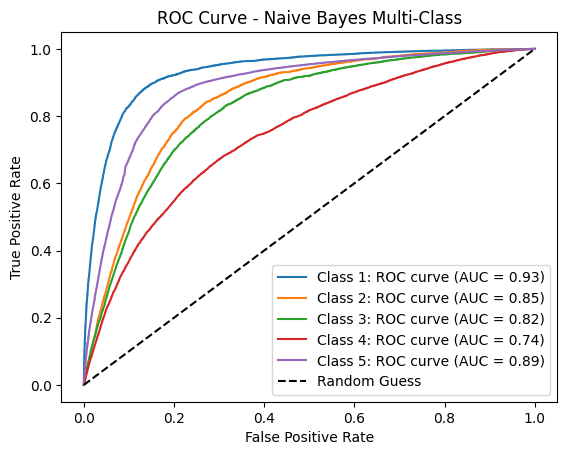

In [22]:
for i in range(len(nb_calssifier.classes_)):
  fpr[i], tpr[i], _ = roc_curve(Y_test == nb_calssifier.classes_[i],y_pred_prob[:,i] )
  roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
for i in range(len(nb_calssifier.classes_)):
    plt.plot(fpr[i], tpr[i], label='Class {}: ROC curve (AUC = {:.2f})'.format(nb_calssifier.classes_[i], roc_auc[i]))

# Add a diagonal line for random guess (comparison baseline)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Label the axes and the plot, and show the legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes Multi-Class')
plt.legend(loc='lower right')

plt.show()